# Seat availability at La Permanence: forecasting using random forests

[La Permanence](https://www.la-permanence.com) offers coworking space at two locations in Paris (*rue du Fer à Moulin* and *rue d'Alésia*).  

In this notebook we investigate the effectiveness of random forests in predicting the number of available seats for the next two weeks.  

The code in this notebook follows closely lessons 1 through 4 of fastai's [Introduction to Machine Learning for Coders](http://course18.fast.ai/ml) course.  The corresponding notebooks from the course's github repository are [lesson1-rf.ipynb and lesson2-rf-interpretation.ipynb](https://github.com/fastai/fastai/tree/master/courses/ml1).  This notebook uses [version 0.7](https://github.com/fastai/fastai/tree/master/old/fastai) of the fastai library.

## Imports

In [1]:
import os
import sys
import re
# import tqdm  # class tqdm.tqdm imported from fastai.structured - see below

import pytz
import datetime

import math
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from scipy.cluster import hierarchy as hc

# The fastai repository is cloned into ~/Computing on my computer
# Version 0.7 of the fastai library is in fastai/old in the repository
sys.path.append(os.path.join(os.path.expanduser("~"), "Computing/fastai/old"))
from fastai.structured import *

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Constants

In [2]:
# Timezones
tz_utc = pytz.timezone("UTC")  # timestamp is in UTC standard
tz_paris = pytz.timezone("Europe/Paris")  # locations are in Paris, France

# Resampling rule: resolution of time regularization
RESOL = 10
RULE = f"{RESOL}T"
TWO_WEEKS = 2*7*24*(60 // RESOL)  # validation period is two weeks

# Colors for plotting
COL_TRAIN = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]
COL_VALID = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]
COL_PREDICT = plt.rcParams['axes.prop_cycle'].by_key()['color'][4]

## Helper functions  

In [3]:
def split_vals(df, n):
    """Split data into training and validation sets."""
    return df[:n].copy(), df[n:].copy()
        
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

## Data
The dataset is saved in a `csv` file located in `~/Projects/la_permanence/attendance.csv`.  

**Note**: `attendance.csv` is a misnomer, as the file actually records the number of *available* seats, rather than the number of seats used.  

### Metadata on the dataset

In [4]:
filename = 'attendance.csv'
foldername = 'Projects/la_permanence'
filepath = os.path.join(os.path.expanduser("~"), foldername, filename)
filesize = os.path.getsize(filepath)

COL_WIDTH = 20  # for display in this cell

if filesize > 1e6:
    print("{0}{1:d}MB".format("File size:".ljust(COL_WIDTH), filesize//int(1e6)))
elif filesize > 1e3:
    print("{0}{1:d}KB".format("File size:".ljust(COL_WIDTH), filesize//int(1e3)))
else:
    print("{0}{1:d}B".format("File size:".ljust(COL_WIDTH), filesize))

line_number = !wc -l < {filepath}
line_number = int(line_number[0])
print("{0}{1}".format("Number of rows:".ljust(COL_WIDTH), line_number))
first_row = !head -1 {filepath}
column_names = first_row[0].split(',')
print("{0}{1}".format("Names of columns:".ljust(COL_WIDTH), ", ".join(column_names)))


File size:          1MB
Number of rows:     40049
Names of columns:   timestamp, Moulin, Alésia


### More details on the columns
-  `timestamp` gives the date and time (UTC) of data collection in the format "YYYY-MM-DD-hh-mm-ss" where
`YYYY=year`,
`MM=month`,
`DD=day`,
`hh=hour`,
`mm=minute`,
`ss=second`;  
-  `Moulin` gives the number of available seats at the rue du Fer à Moulin location (maximum is 63);
-  `Alésia` gives the number of available seats at the rue d'Alésia location (maximum is 82).  

### Load the data

In [5]:
# %%prun
%time
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d-%H-%M-%S')

raw_data = pd.read_csv(
    filepath,
    sep=',',
    dtype={'Moulin': np.uint8, 'Alésia': np.uint8},
    parse_dates=['timestamp'],
    date_parser=dateparse
)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


### Selecting data from rue du Fer à Moulin
For clarity we will concentrate on the data from rue du Fer à Moulin.  

In [6]:
availability = raw_data.copy()
availability.drop('Alésia', axis=1, inplace=True)

### Adjusting for timezones

The `timestamp` values are in the UTC standard, while the coworking spaces are located in Paris, France:

In [7]:
%time
availability['timestamp'] = availability['timestamp'].apply(lambda ts: ts.tz_localize(tz_utc).tz_convert(tz_paris))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.72 µs


### Time regularization

As explained in notebook `la-permanence-EDA.ipynb`, the data is collected at irregular times and thus we resample (at a resolution specified in `RULE`) and interpolate to regularize the data:

In [8]:
availability.set_index("timestamp", inplace=True)
availability = availability.resample(RULE).mean().interpolate().round().astype(np.uint8)
availability.reset_index('timestamp', inplace=True)

### Visualizing the time series

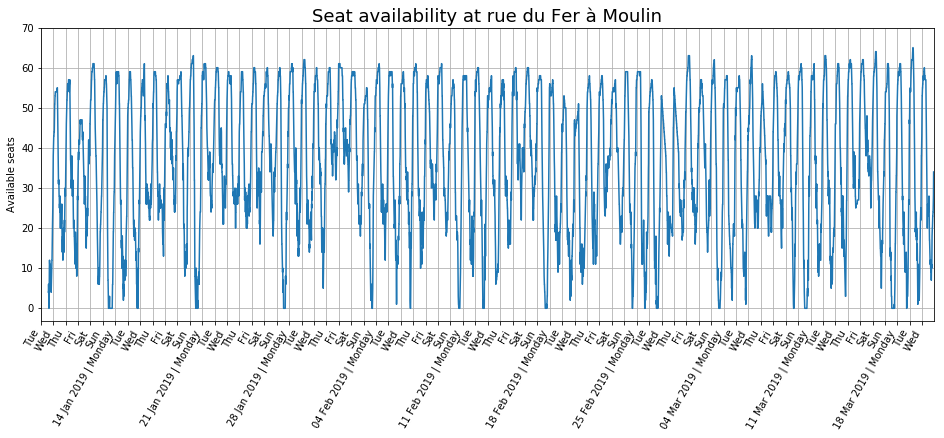

In [9]:
fig, ax = plt.subplots(figsize=(16, 6));
availability.plot(x='timestamp', y='Moulin', ax=ax);

ax.set_title("Seat availability at rue du Fer à Moulin", fontsize=18)

ax.set_ylabel("Available seats");
ax.set_yticks(range(0, 80, 10))

ax.axes.get_xaxis().label.set_visible(False);
ts_min = availability['timestamp'].min()
ts_max = availability['timestamp'].max()
availability_date_range = pd.date_range(ts_min.date(), ts_max.date());
ax.set_xticks(availability_date_range);
ax.set_xticklabels([pd.to_datetime(x).strftime("%d %b %Y | %A")
                     if x.weekday() in [0]
                     else pd.to_datetime(x).strftime("%a")
                     for x in availability_date_range])
ax.tick_params(axis='x', labelrotation=60)

ax.get_legend().remove();
ax.grid()
# plt.savefig("La-Permanence-availability.png")

## Expanding date information

The next cell extracts particular date fields from a complete datetime for the purpose of constructing categoricals: `Year`, `Month`, `Week`, `Day`, `Dayofweek`, `Dayofyear`, `Is_month_end`, `Is_month_start`, `Is_quarter_end`, `Is_quarter_start`, `Is_year_end`, `Is_year_start`, `Hour`, `Minute`, `Second`.  Of course, not all of these will be useful or even relevant, and for the purpose of exploration we keep them all in the dataframe for the moment.  

In [10]:
timestamps = availability.loc[:, ['timestamp']]
add_datepart(availability, 'timestamp', time=True)

## Separating dependent from independent variables  
The following could be done by hand, but the custom function `proc_df` can perform additional transformations which are useful in the general case.

In [11]:
df, y, nas = proc_df(availability, 'Moulin')

## Splitting data into training and validation sets  

In [12]:
n_valid = TWO_WEEKS  
n_trn = availability.shape[0] - n_valid

X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

# For plotting purposes:
timestamps_train = timestamps.iloc[0:n_trn].copy()
timestamps_valid = timestamps.iloc[n_trn:].copy()

## Visualizing the training and validation sets

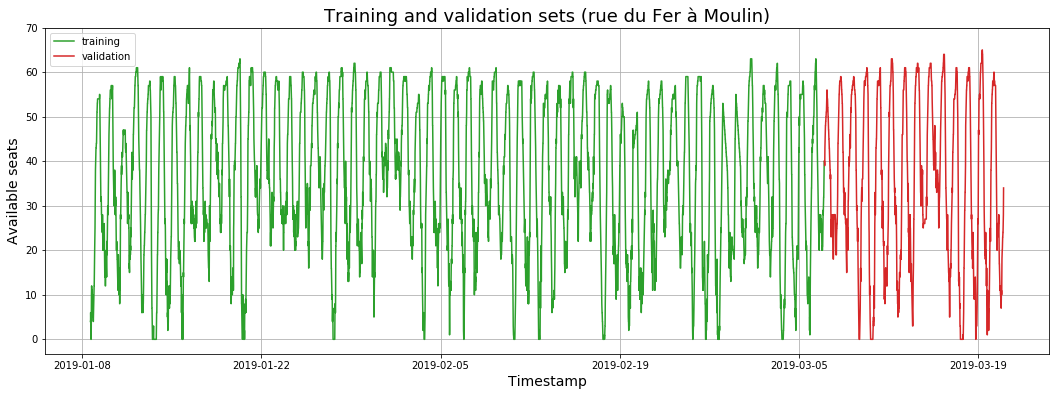

In [13]:
fig, ax = plt.subplots(figsize=(18, 6));

plt.plot(timestamps_train['timestamp'], y_train, COL_TRAIN);
plt.plot(timestamps_valid['timestamp'], y_valid, COL_VALID);

ax.set_title("Training and validation sets (rue du Fer à Moulin)", fontsize=18)

ax.set_ylabel("Available seats", fontsize=14);
ax.set_yticks(range(0, 80, 10));

ax.set_xlabel("Timestamp", fontsize=14);

ax.legend(['training', 'validation'])
ax.grid();
# plt.savefig("moulin-training-validation-split.png")

## Metrics used to assess performance of models

We will use the root mean squared error (RMSE) and $R^2$ score to assess the predictions.  If various models are applied to the same dataset, then RMSE and $R^2$ provide the same qualitative information, in the sense that optimal choices of the model's parameters are the same whether the metric used is RMSE or $R^2$.  

## Random forests

### Using default values

We first use random forests with default values.  As of now, the default value for `n_estimators` in [`sklearn.RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) is 10, although it will be changed to 100.  

In [14]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=10)
%time m.fit(X_train, y_train)
COL_WIDTH = 20
print("{0}: {1}".format("RMSE (train)".ljust(COL_WIDTH), rmse(m.predict(X_train), y_train)))
print("{0}: {1}".format("RMSE (validation)".ljust(COL_WIDTH), rmse(m.predict(X_valid), y_valid)))
print("{0}: {1}".format("R2 (train)".ljust(COL_WIDTH), m.score(X_train, y_train)))
print("{0}: {1}".format("R2 (validation)".ljust(COL_WIDTH), m.score(X_valid, y_valid)))

y_predict = m.predict(X_valid)

CPU times: user 233 ms, sys: 6.54 ms, total: 240 ms
Wall time: 117 ms
RMSE (train)        : 0.6895025662934399
RMSE (validation)   : 9.266863382204598
R2 (train)          : 0.9984168862286388
R2 (validation)     : 0.7648324771464752


The performance as measured on the training is not suprisingly very high, but that on the validation set is nevertheless promising.

### Visualizing the predictions

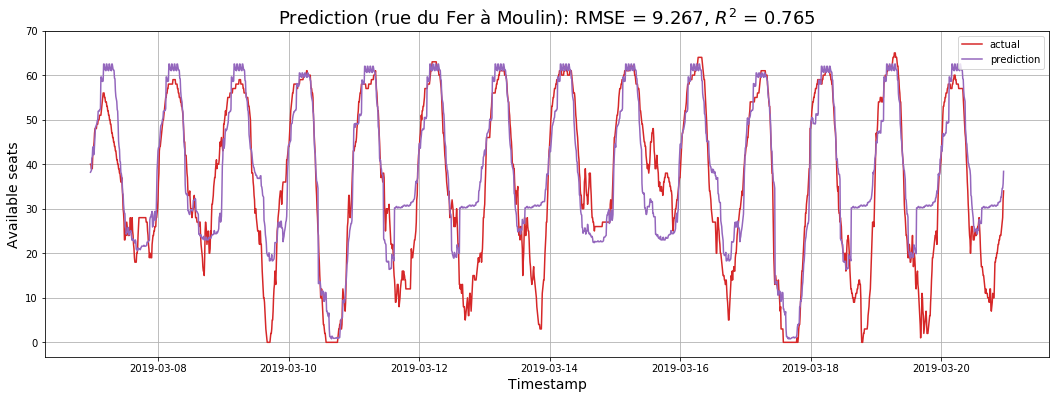

In [15]:
fig, ax = plt.subplots(figsize=(18, 6));
ax.plot(timestamps_valid['timestamp'], y_valid, COL_VALID);
ax.plot(timestamps_valid['timestamp'], y_predict, COL_PREDICT);
ax.set_title(
    "Prediction (rue du Fer à Moulin): RMSE = {0:.4g}, $R^2$ = {1:.3g}".format(
        rmse(m.predict(X_valid), y_valid),
        m.score(X_valid, y_valid)
    ),
    fontsize=18
)

ax.set_ylabel("Available seats", fontsize=14);
ax.set_yticks(range(0, 80, 10));
ax.set_xlabel("Timestamp", fontsize=14);
ax.legend(['actual', 'prediction'], loc='upper right')
ax.grid();

### First impressions
Random forests are reasonably effective in forecasting seat availability.  The question now is whether the results can be improved by tuning the parameters.   

## Impact of the parameters 

There are many parameters in [`sklearn.RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) that can be adjusted in order to improve the predictions.  We will focus on the following.  
-  The number of trees: `nb_estimators`.  The default value is (currently) **10**.   
-  The minimum number of samples required to be at a leaf node: `min_leaves_sample`.  The default value is **1**.  
-  The maximum number of features to consider when looking for the best split: `max_features`.  The default is to use **all** features.  

### The number of trees  
We measure the RMSE and $R^2$ for a range of number of trees.

In [16]:
# NB_TREES = (1, 2, 5, 10, 20, 50, 100, 200)
NB_TREES = range(1, 25)
# NB_TREES = [2**i for i in range(0, 6)]
# NB_TREES = [i**2 for i in range(1, 6)]

train_rmse = []
valid_rmse = []
train_r2 = []
valid_r2 = []

for n in tqdm(NB_TREES):
    m = RandomForestRegressor(n_jobs=-1, n_estimators=n)
    m.fit(X_train, y_train)
    train_rmse.append(rmse(m.predict(X_train), y_train))
    valid_rmse.append(rmse(m.predict(X_valid), y_valid))
    train_r2.append(m.score(X_train, y_train))
    valid_r2.append(m.score(X_valid, y_valid))



100%|██████████| 24/24 [00:13<00:00,  1.76it/s]


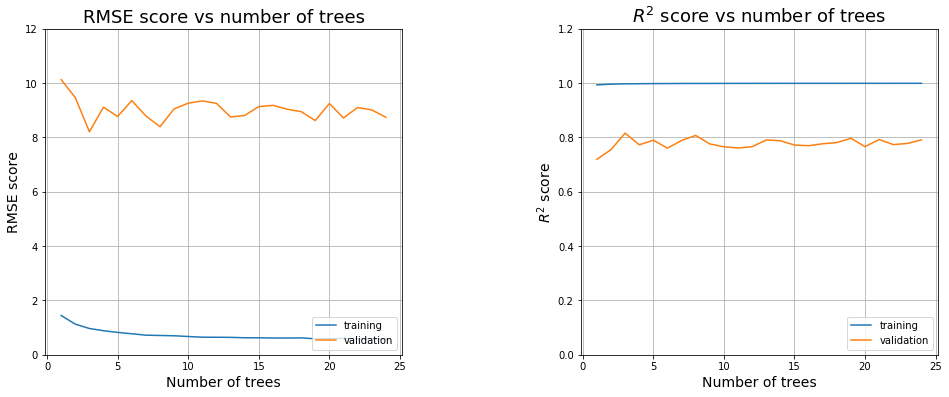

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6));

ax1.plot(NB_TREES, train_rmse)
ax1.plot(NB_TREES, valid_rmse)

ax1.set_title("RMSE score vs number of trees", fontsize=18)
ax1.set_ylabel("RMSE score", fontsize=14);
ax1.set_ylim([0, 12]);
ax1.set_xlabel("Number of trees", fontsize=14);
ax1.legend(['training', 'validation'], loc='lower right');
ax1.grid();

plt.subplots_adjust(wspace=.5);

ax2.plot(NB_TREES, train_r2)
ax2.plot(NB_TREES, valid_r2)

ax2.set_title("$R^2$ score vs number of trees", fontsize=18)
ax2.set_ylabel("$R^2$ score", fontsize=14);
ax2.set_ylim([0, 1.2]);
ax2.set_xlabel("Number of trees", fontsize=14);
ax2.legend(['training', 'validation'], loc='lower right');
ax2.grid();

This suggests that beyond 5 trees the random forest is not fundamentally improved.  We fix this parameter to 10, which is (currently) the default value in `scikit-learn`'s `RandomForestRegressor`:

In [18]:
nb_trees = 10

Later, when the optimal values for `min_samples_leaf` and `max_features` are fixed, we will look at the effect of using a larger `nb_trees`.  We will see that this has the effect of making the results more stable.

### Minimum number of leaves and maximum number of features

We again measure RMSE and $R^2$, but now for a range of values of `min_samples_leaf` and `max_features`:

In [19]:
MIN_LEAVES = [2**i for i in range(10)]
MAX_FEATURES = range(1, len(df.columns)+1, 2)

performance_list = []

for i, j in tqdm([(x, y) for x in MIN_LEAVES for y in MAX_FEATURES]):
    m = RandomForestRegressor(n_jobs=-1, n_estimators=nb_trees, min_samples_leaf=i, max_features=j)
    m.fit(X_train, y_train)
    D = {
        'min leaves': i,
        'max features': j,
        'rmse': rmse(m.predict(X_valid), y_valid),
        'R2': m.score(X_valid, y_valid)
    }
    performance_list.append(D)

100%|██████████| 80/80 [00:27<00:00,  2.98it/s]


In [20]:
performance = pd.DataFrame(performance_list)[['min leaves', 'max features', 'rmse', 'R2']]

df_rmse = pd.pivot_table(performance, index='min leaves', columns='max features', values='rmse')
df_r2 = pd.pivot_table(performance, index='min leaves', columns='max features', values='R2')

Plot heatmaps for RMSE and $R^2$, with different color maps so that **darker colors mean better results** in both cases:

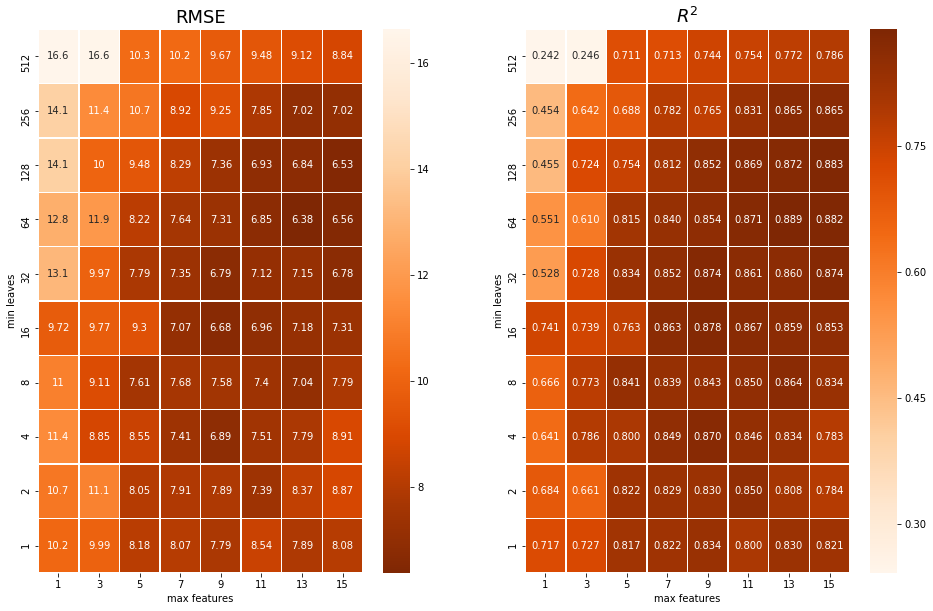

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10));
plt.subplots_adjust(wspace=0.2);
sns.heatmap(df_rmse.sort_index(ascending=False), annot=True, cmap="Oranges_r", linewidths=.5, fmt='.3g', ax=ax1);
ax1.set_title("RMSE", fontsize=18);
sns.heatmap(df_r2.sort_index(ascending=False), annot=True, cmap="Oranges", linewidths=.5, fmt='.3f', ax=ax2);
ax2.set_title("$R^2$", fontsize=18);

The heatmaps show a decent level of regularity, though not perfect.  We will see later that increasing the number of trees will increase this regularity and improve the stability of the predictions.

At this point the heatmaps suggest that  
1. a higher number of features generally provides better results; and that  
1. better results are obtained for `min_samples_leaf` that are not too large, say no more than 256.  


### The optimizing pair (`max_features`, `mim_samples_leaf`)


From the run above we can extract the optimizer:

In [22]:
sort_rmse = performance.sort_values('rmse')[['min leaves', 'max features']]
min_leaves, max_features = tuple(sort_rmse.iloc[0])
min_leaves, max_features

(64, 13)

### Train the random forests

In [23]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=nb_trees, min_samples_leaf=min_leaves, max_features=max_features)
m.fit(X_train, y_train)
y_predict = m.predict(X_valid)

### Visualize the predictions

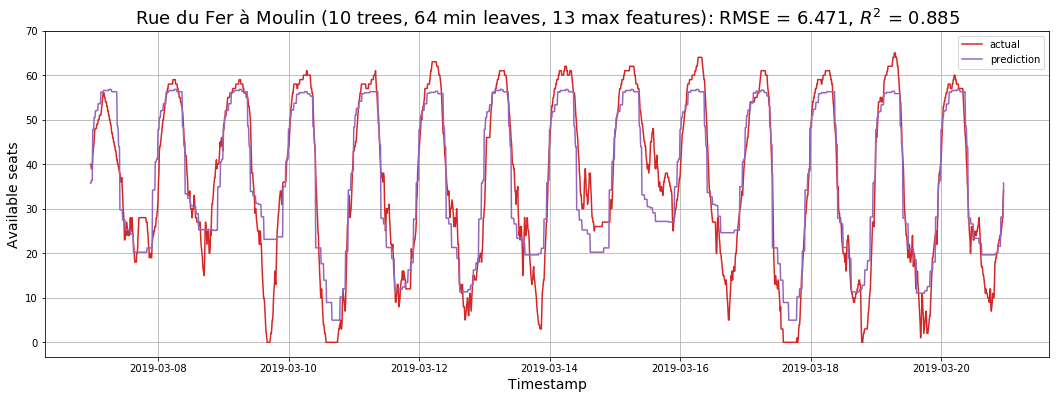

In [24]:
fig, ax = plt.subplots(figsize=(18, 6));
ax.plot(timestamps_valid['timestamp'], y_valid, COL_VALID);
ax.plot(timestamps_valid['timestamp'], y_predict, COL_PREDICT);
ax.set_title(
    "Rue du Fer à Moulin ({2} trees, {3} min leaves, {4} max features): RMSE = {0:.4g}, $R^2$ = {1:.3g}".format(
        rmse(m.predict(X_valid), y_valid),
        m.score(X_valid, y_valid),
        nb_trees,
        min_leaves,
        max_features
    ),
    fontsize=18
)
ax.set_ylabel("Available seats", fontsize=14);
ax.set_yticks(range(0, 80, 10));
ax.set_xlabel("Timestamp", fontsize=14);
ax.legend(['actual', 'prediction'], loc='upper right')
ax.grid();
# plt.savefig("moulin-random-forests.png")

## Confirming first impressions

Random forests are quite good at picking up the general trend but not quite as good in detecting particularly high attendance (low availability) at the coworking spaces.  The results are not significantly improved by optimizing over the parameters `min_samples_leaf` and `max_features`.  

## Feature importance
In this section we interpret the model.

Let's run again a random forest with the parameters set as above:

In [25]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=nb_trees, min_samples_leaf=min_leaves, max_features=max_features)
m.fit(X_train, y_train)

COL_WIDTH = 20
print("{0}: {1}".format("RMSE (train)".ljust(COL_WIDTH), rmse(m.predict(X_train), y_train)))
print("{0}: {1}".format("RMSE (validation)".ljust(COL_WIDTH), rmse(m.predict(X_valid), y_valid)))
print("{0}: {1}".format("R2 (train)".ljust(COL_WIDTH), m.score(X_train, y_train)))
print("{0}: {1}".format("R2 (validation)".ljust(COL_WIDTH), m.score(X_valid, y_valid)))



[4.891396532292525, 6.599716111129618, 0.9203279309817661, 0.8807214549668059]


Calculate feature importance:

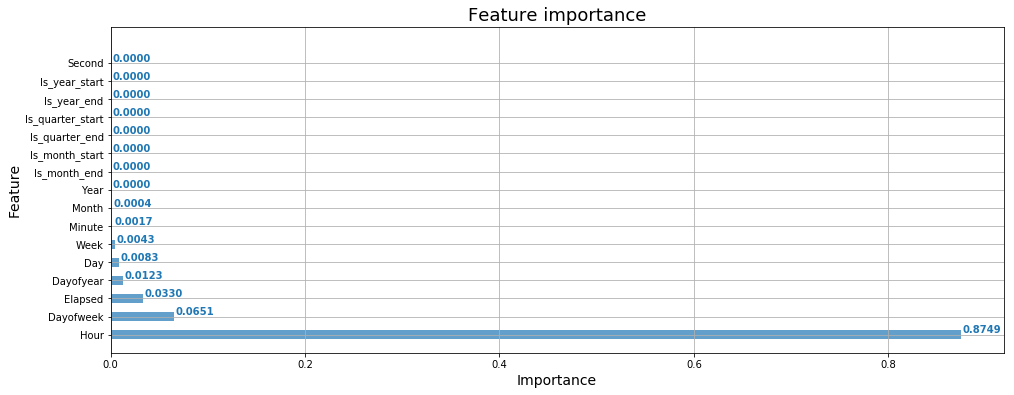

In [26]:
fi = rf_feat_importance(m, df)

fig, ax = plt.subplots(figsize=(16, 6));
fi.plot('cols', 'imp', 'barh', ax=ax, legend=False, alpha=0.7);
for i, v in enumerate(fi['imp']):
    ax.text(v + .002, i + .1, "{:.4f}".format(v), color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], fontweight='bold');
ax.set_ylim([-1, fi.shape[0]+1])
ax.set_yticklabels([col.replace('timestamp', '') for col in fi['cols']])
ax.set_ylabel("Feature", fontsize=14);
ax.set_xlabel("Importance", fontsize=14);
ax.set_title("Feature importance", fontsize=18);
plt.grid();

### Interpretation
This table looks mostly as expected and we can interpret these results as follows.  
- The `Hour` has by far the highest importance as it controls the 24-hour seasonality, which is by far the strongest variation in the signal.  
- The `Dayofweek` has some importance as it controls the 7-day seasonality.  
- The `Elapsed` time and the `Dayofyear`  have some importance as they reflect the long term trend of the data.  
- The `Day` (of month) has comparable importance, possibly because over such a short timespan it is quite closely related to the `Elapsed` time.  
- The `Week` has little importance, possibly because it is highly correlated with the `Elapsed` time (the data is all within the same year).  
- The precise time within an hour (`Minute`) has little importance.  This is perhaps due to the quality of the data: in this particular dataset, data is collected at irregular times and thus regularized and interpolated.  Working with more precise data (collected every minute, say) will probably yield more accurate results, where `Minute` has a higher importance.  
- For such a short timespan, the `Month`, and the `Is_month_start` and `Is_month_end` features have very little importance.  
- Since the data is all near the beginning of the same year, the features with `Second`, `Year`, `Is_year_end`, `Is_year_start`, `Is_quarter_end`, `Is_quarter_start` play absolutely no role.  

The fact that one feature, `Hour`, is far more significant than any other, is consistent with the fact that the optimizer is with `max_features` less than the total number of features.



Let's keep only the reasonably significant features:

In [27]:
to_keep = fi[fi.imp>0.002].cols
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

## Removing redundant features with hierarchical clustering


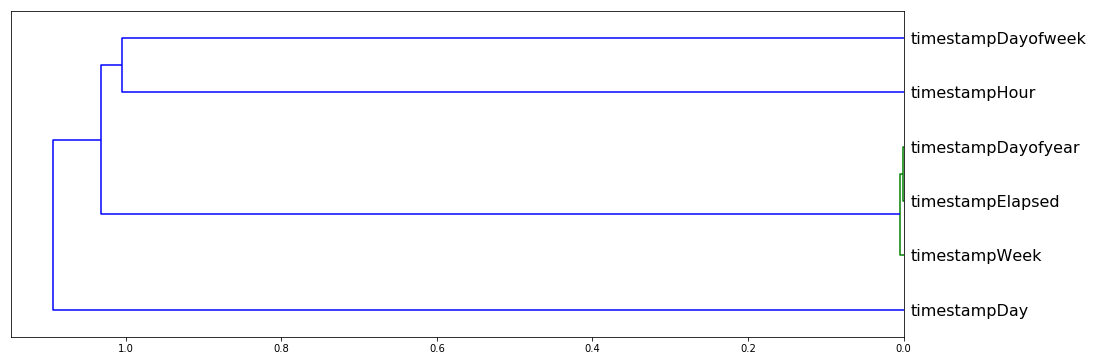

In [28]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1 - corr)
z = hc.linkage(corr_condensed, method='average')

fig = plt.figure(figsize=(16, 6));
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16);

As already anticipated, the three features `Elapsed` time, `Dayofyear` and `Week` are closely related.  Removing any one of these features should not significantly impact the results:

In [29]:
for feat in ['timestampDayofyear', 'timestampElapsed', 'timestampWeek']:
    m = RandomForestRegressor(n_jobs=-1, n_estimators=nb_trees, min_samples_leaf=8)
    x, _ = split_vals(df_keep, n_trn)
    m.fit(x, y_train)
    print("Score without {0} : {1:.4g}".format(feat.replace('timestamp', '').ljust(12), m.score(X_valid, y_valid)))

Score without Dayofyear    : 0.8069
Score without Elapsed      : 0.8203
Score without Week         : 0.8221


The `Elapsed` time feature is the finest of the three and (depending on the run) we should see that the results are most impacted by removing it.  

Let's then remove the other two features, `Week` and `Dayofyear`:

In [30]:
to_drop = ['timestampDayofyear', 'timestampWeek']
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_jobs=-1, n_estimators=nb_trees, min_samples_leaf=8)
x, _ = split_vals(df_keep, n_trn)
m.fit(x, y_train)
m.score(X_valid, y_valid)

0.8351031550804439

## The effect of increasing the number of trees

In this section we illustrate how using a large number of trees has the effect of stabilizing the predictions.  

We return to the original dataset:

In [31]:
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

We will also choose a larger set of values for the parameters `min_samples_leaf` and `max_features`:

In [32]:
# MIN_LEAVES = [2**i for i in range(10)]
# MIN_LEAVES = [i**2 for i in range(1, 21)]
# MIN_LEAVES = [int(i+0.5*i**2) for i in range(1, 20)]
MIN_LEAVES = [int(i+0.2*i**2) for i in range(1, 50)]
MAX_FEATURES = range(len(df.columns) // 3, len(df.columns)+1)

Recalculate the performance for `nb_trees` as above:

In [33]:
nb_trees

10

In [34]:
performance_list = []

for i, j in tqdm([(x, y) for x in MIN_LEAVES for y in MAX_FEATURES]):
    m = RandomForestRegressor(n_jobs=-1, n_estimators=nb_trees, min_samples_leaf=i, max_features=j)
    m.fit(X_train, y_train)
    D = {
        'min leaves': i,
        'max features': j,
        'rmse': rmse(m.predict(X_valid), y_valid),
        'R2': m.score(X_valid, y_valid)
    }
    performance_list.append(D)

100%|██████████| 588/588 [03:20<00:00,  2.92it/s]


In [35]:
performance_low_nb_trees = pd.DataFrame(performance_list)[['min leaves', 'max features', 'rmse', 'R2']]
df_rmse_low_nb_trees = pd.pivot_table(performance_low_nb_trees, index='min leaves', columns='max features', values='rmse')
df_r2_low_nb_trees = pd.pivot_table(performance_low_nb_trees, index='min leaves', columns='max features', values='R2')

Repeat with (many) more trees:

In [36]:
nb_trees_high = 10*nb_trees
nb_trees_high

100

In [37]:
performance_list = []

for i, j in tqdm([(x, y) for x in MIN_LEAVES for y in MAX_FEATURES]):
    m = RandomForestRegressor(n_jobs=-1, n_estimators=nb_trees_high, min_samples_leaf=i, max_features=j)
    m.fit(X_train, y_train)
    D = {
        'min leaves': i,
        'max features': j,
        'rmse': rmse(m.predict(X_valid), y_valid),
        'R2': m.score(X_valid, y_valid)
    }
    performance_list.append(D)

100%|██████████| 588/588 [03:46<00:00,  2.72it/s]


In [38]:
performance_high_nb_trees = pd.DataFrame(performance_list)[['min leaves', 'max features', 'rmse', 'R2']]
df_rmse_high_nb_trees = pd.pivot_table(performance_high_nb_trees, index='min leaves', columns='max features', values='rmse')
df_r2_high_nb_trees = pd.pivot_table(performance_high_nb_trees, index='min leaves', columns='max features', values='R2')

Plot the $R^2$ scores for low and high number of trees side by side:

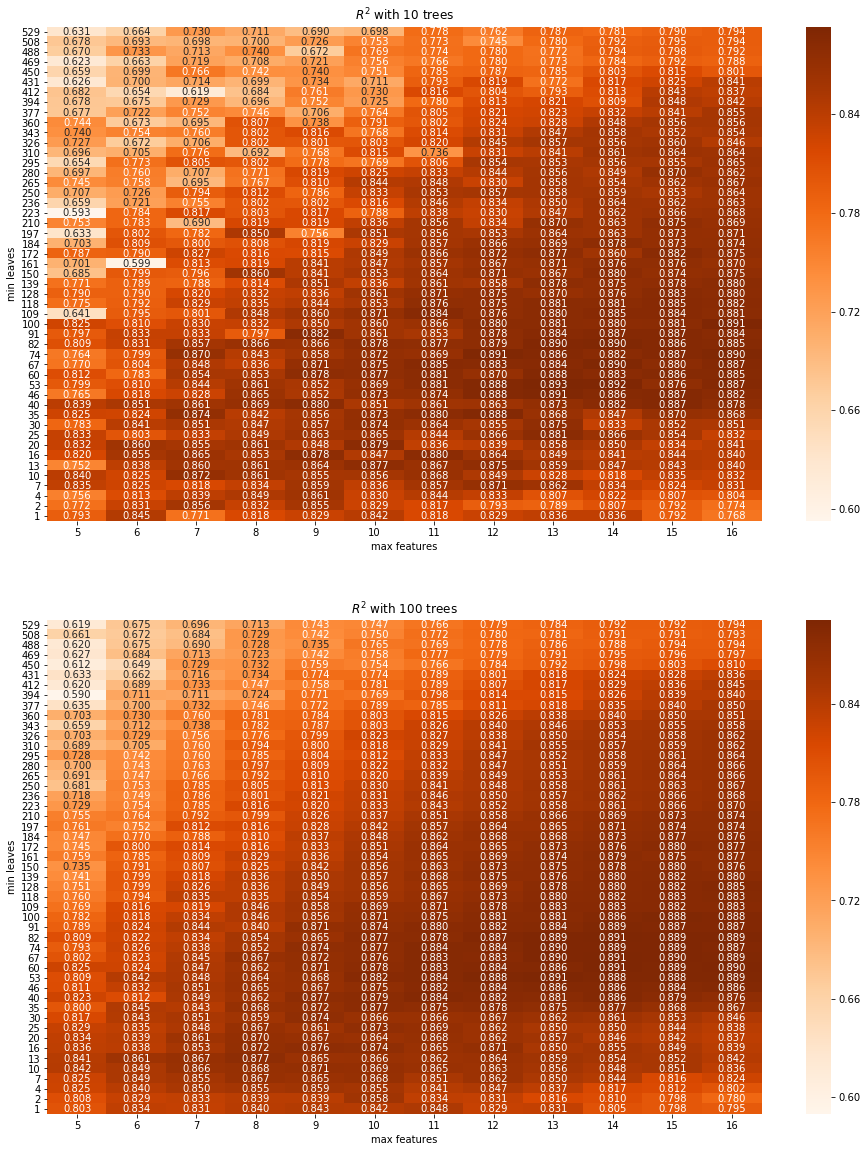

In [39]:
fig, (ax1, ax2) = plt.subplots(2, 1 , figsize=(16, 20));
plt.subplots_adjust(wspace=0.1);
sns.heatmap(df_r2_low_nb_trees.sort_index(ascending=False), annot=True, cmap="Oranges", linewidths=0, fmt='.3f', ax=ax1);
ax1.set_title("$R^2$ with {0} trees".format(nb_trees));
sns.heatmap(df_r2_high_nb_trees.sort_index(ascending=False), annot=True, cmap="Oranges", linewidths=0, fmt='.3f', ax=ax2);
ax2.set_title("$R^2$ with {0} trees".format(nb_trees_high));

The heatmap with higher number of trees shows a lot more regularity, thereby indicating that the results are more stable.  
On the other hand, it reveals that the performance is not a monotonic function of the parameters.

In [45]:
sort_performance = performance_high_nb_trees.sort_values('rmse')

min_leaves, max_features = tuple(sort_performance.iloc[0][['min leaves', 'max features']])
min_leaves, max_features

(82.0, 14.0)

The optimal performance is marginally higher than with the default values:

In [46]:
sort_performance[(sort_performance['min leaves'] == min_leaves) & (sort_performance['max features'] == max_features)]

,min leaves,max features,rmse,R2
213,82,14,6.30472,0.891146


This optimizer depends on the run.  Instead, we should be looking for the region of "near optimizers":

In [57]:
max_r2 = sort_performance['R2'].max()
sort_performance[sort_performance['R2'] > max_r2 - 0.01].describe()

,min leaves,max features,rmse,R2
count,59.000000,59.000000,59.000000,59.000000
mean,75.644068,13.745763,6.456610,0.885818
std,25.917484,1.697800,0.086917,0.003071
min,40.000000,10.000000,6.304720,0.881203
25%,53.000000,12.000000,6.374082,0.882978
50%,74.000000,14.000000,6.452094,0.885998
75%,91.000000,15.000000,6.536986,0.888738
max,139.000000,16.000000,6.586367,0.891146


In [58]:
r2_scores = df_r2_high_nb_trees.copy()


In [70]:
performance = performance_high_nb_trees.copy()
performance['near max'] = performance['R2'] > max_r2 - 0.01
performance['near max'] = performance['near max'].map({False: 0, True: 1})
performance_pivot = pd.pivot_table(performance, index='min leaves', columns='max features', values='near max')


# performance.sample(20)

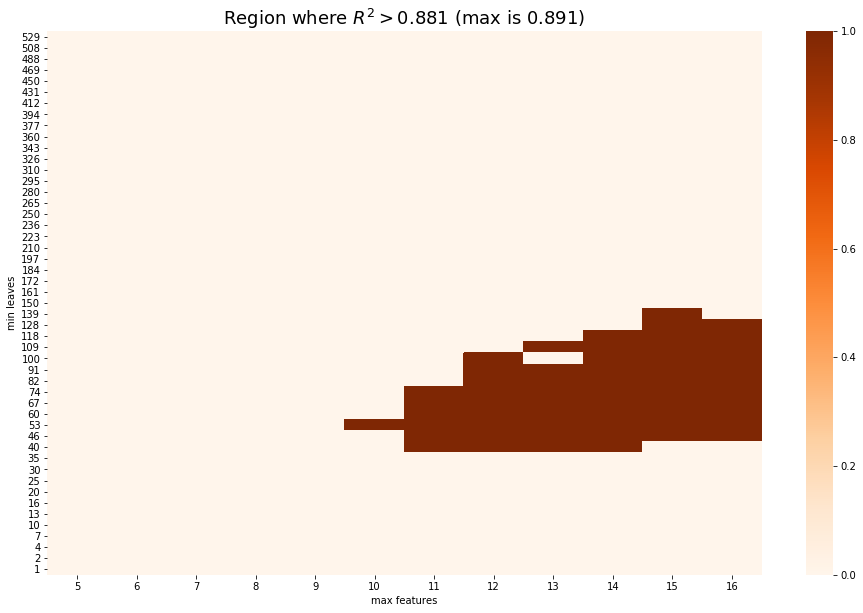

In [76]:
fig, ax= plt.subplots(figsize=(16, 10));
sns.heatmap(performance_pivot.sort_index(ascending=False), cmap="Oranges", linewidths=0, fmt='.3f', ax=ax);
ax.set_title("Region where $R^2>{0:.3f}$ (max is {1:.3f})".format(max_r2 - 0.01, max_r2), fontsize=18);

## Further questions
The metrics RMSE $R^2$ measure the accuracy to which the random forests is able to predict the number of available seats.  It is however of more practical use to accurately estimate the number of available seats when there are few (at peak times) rather than in the middle of the night when there are many.  This means that weighted metrics should be used instead.  